In [1]:
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import glob
import os
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import imgaug.augmenters as iaa
import scipy.io
import tensorflow as tf
import seaborn as sns

In [2]:
data_dir = "MPIIGaze/Data/Normalized"
list_ds = tf.data.Dataset.list_files(str(data_dir+'/*/*'))
data = []
labels = []
for strs in list_ds:
    mat = scipy.io.loadmat(strs.numpy())
    for picnum in range(len(mat['data'][0][0][0][0][0][1])):
        for i in range(2):
            img = mat['data'][0][0][i][0][0][1][picnum]
            img = Image.fromarray(img)
            img = np.array(img)
            img = img.reshape((36, 60, 1))
            data.append(img / 255) 
            labels.append(mat['data'][0][0][i][0][0][0][picnum])

mat['data'][0][0][0][0][0][0] some 3d vector <br>
mat['data'][0][0][0][0][0][1] eyes maybe <br>
mat['data'][0][0][0][0][0][2] some 3d vector


mat['data'][0][0][eye_num] eye num

In [3]:
"""data = tf.data.Dataset.from_tensor_slices(data)
labels = tf.data.Dataset.from_tensor_slices(labels)"""
data = np.array(data)
labels = np.array(labels)


import copy
from functools import partial
def get_pixel(tens, a, b, c, d,
              width=0.54, heigth=0.30375,
              pixel_width=1920, pixel_heigth=1080):
    [x, y, z] = tens
    k = -d / (a * x + b * y + c * z)
    x = k * x
    y = k * y
    z = k * z
    pixel_x = x / width * pixel_width
    pixel_y = y / heigth * pixel_heigth
    return pixel_x, pixel_y
pxlf = partial(get_pixel,a=0, b=0, c=1, d=-1)
xlist, ylist = [], []
for img in labels:
    x, y = pxlf(img)
    xlist.append(x)
    ylist.append(y)

sns.jointplot(x=xlist, y=ylist, kind="hex", color="k");

In [10]:
"""dataset = tf.data.Dataset.zip((data, labels))"""
NUM_BATCHES = 32
def generatorr(data, labels):
    order_list = np.arange(len(data) )
    order_list = np.random.permutation(order_list)
    affine = iaa.Affine(scale=(0.95,1.05), translate_percent=(-0.05,0.05),)
    noise = iaa.Sequential([
        iaa.Sometimes(then_list=iaa.AdditiveGaussianNoise(scale=(0, 0.03), per_channel=True)),
      #  iaa.Sometimes(then_list=iaa.AdditivePoissonNoise(lam=(0, 1), per_channel=True)),
        #iaa.Sometimes(then_list=iaa.SaltAndPepper(p=(0,0.1)))
    ])
    blur = iaa.OneOf([
        #iaa.GaussianBlur(sigma=(0.2, 0.6)),
    ])
    augmentation = iaa.Sequential([blur, noise, affine])
    augmented_list = []
    augmented_lavels = []

    for i in range(len(order_list) - 4 * NUM_BATCHES):
        if len(augmented_list) == 0:
            augmented_list = [np.ndarray.astype(data[order_list[i+j]], dtype=np.float32) for j in range(NUM_BATCHES)]

            augmented_labels = [labels[order_list[i+j]] for j in range(NUM_BATCHES)]
            
            augmented_list = augmentation.augment_images(augmented_list)
            
        pic = augmented_list[0]
        augmented_list = augmented_list[1:]
        label = augmented_labels[0]
        augmented_labels = augmented_labels[1:]
        
        yield pic, label
test_data = data[:int(len(data)*0.2)]
train_data = data[int(len(data)/5):]
test_labels = labels[:int(len(data)/5)]
train_labels = labels[int(len(data)/5):]
import functools
train_dataset = tf.data.Dataset.from_generator(functools.partial(generatorr, train_data, train_labels),
                                              output_types=(tf.float32, tf.float32),
                                               output_shapes=((36, 60, 1), (3))
                                             )
test_dataset = tf.data.Dataset.from_generator(functools.partial(generatorr, test_data, test_labels),
                                              output_types=(tf.float32, tf.float32),
                                               output_shapes=((36, 60, 1), (3))
                                             )
train_dataset = train_dataset.batch(NUM_BATCHES,drop_remainder=True)
test_dataset = test_dataset.batch(NUM_BATCHES,drop_remainder=True)

import math
@tf.function
def get_pixel(tens, a, b, c, d, 
              width=0.54, heigth=0.30375, 
              pixel_width=1920, pixel_heigth=1080):
    """k = -d / (a * x + b * y + c * z)
    print(x[0].item())
    x = k * x
    y = k * y
    z = k * z
    pixel_x = x / width * pixel_width
    pixel_y = y / heigth * pixel_heigth
    return pixel_x, pixel_y """
    fl = np.array([a, b, c])
    ratios = np.array([width * pixel_width, heigth * pixel_heigth])
    bottom = tf.math.reduce_sum(tens * fl, 1)
    k = d / (tf.math.reduce_sum(tens * fl, 1))
    k = tf.convert_to_tensor([k, k, k])
    k = tf.transpose(k)
    tens = tens * k
    tens = tens[:, 0:2]
    tens = tens * ratios
    return tens
kek = tf.convert_to_tensor([1e-8 for i in range(NUM_BATCHES)], dtype=tf.float32)

@tf.function
def generic_pixel_loss(y_true, y_pred, pixel_func, sample_weight=0):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    pix_pred = pixel_func(y_pred)
    pix_true = pixel_func(y_true)
    return tf.reduce_mean(tf.sqrt(tf.square(pix_pred - pix_true)))

from functools import partial
pixel_loss = partial(generic_pixel_loss, pixel_func=
                    partial(get_pixel,
                           a=0, b=0, c=1, d=-1))

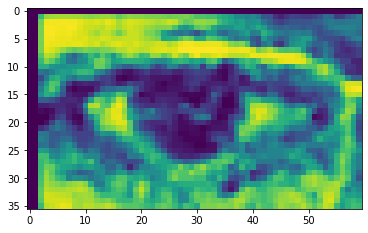

tf.Tensor([-0.20739782  0.23920833 -0.9485597 ], shape=(3,), dtype=float32)


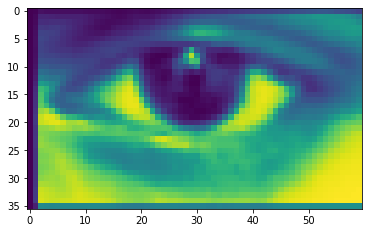

tf.Tensor([-0.09229501  0.02927784 -0.9953012 ], shape=(3,), dtype=float32)


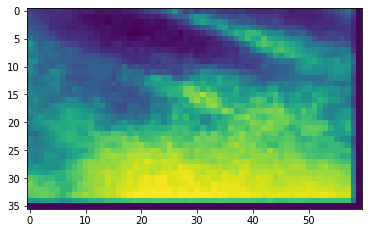

tf.Tensor([ 0.00582163  0.22299753 -0.9748016 ], shape=(3,), dtype=float32)


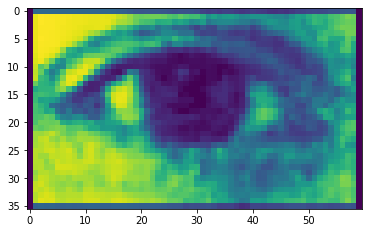

tf.Tensor([-0.01646673  0.09501359 -0.99533975], shape=(3,), dtype=float32)


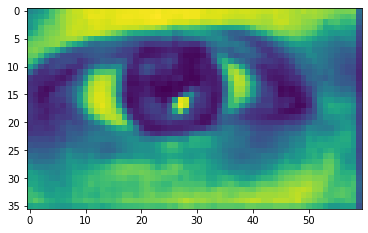

tf.Tensor([ 0.07304821  0.11110866 -0.99112   ], shape=(3,), dtype=float32)


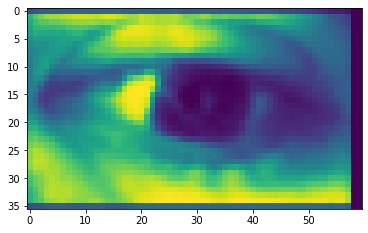

tf.Tensor([ 0.12534118  0.24178351 -0.96220076], shape=(3,), dtype=float32)


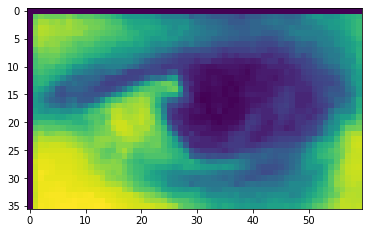

tf.Tensor([ 0.08290754  0.14675929 -0.98569167], shape=(3,), dtype=float32)


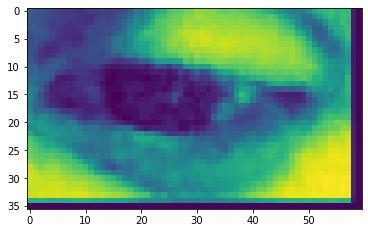

tf.Tensor([-0.03903658  0.30501306 -0.9515478 ], shape=(3,), dtype=float32)


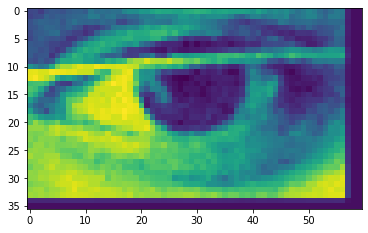

tf.Tensor([ 0.11752298  0.11936276 -0.9858706 ], shape=(3,), dtype=float32)


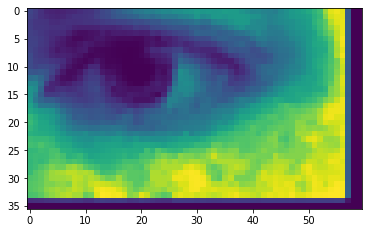

tf.Tensor([-0.17891695  0.06557228 -0.98167664], shape=(3,), dtype=float32)


In [11]:
for a, b in train_dataset.take(10):
    plt.imshow(np.array(a[0]).reshape(36, 60))
    plt.show()
    print(b[0])

In [7]:
import sys
sys.path.append("watcher/")
import model as model_generator
import importlib
importlib.reload(model_generator)
model = model_generator.get_model()



"""with tf.GradientTape() as tape:
    values = model(pics[:32], training=True)
    loss_value = pixel_loss(values, coords_1[0:32])
    print(loss_value)"""

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 36, 60, 1)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1500)              904650    
_________________________________________________________________
dense_4 (Dense)              (None, 1500)              2251500   
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 4503      
Total params: 3,160,653
Trainable params: 3,160,413
Non-trainable params: 240
_________________________________________________________________


'with tf.GradientTape() as tape:\n    values = model(pics[:32], training=True)\n    loss_value = pixel_loss(values, coords_1[0:32])\n    print(loss_value)'

In [11]:
class my_callback(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs={}):
        if(tf.math.is_nan(logs['loss'])):
            tf.print(batch)
            self.model.stop_training = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(clipnorm=1.), 
    loss="MSE")#pixel_loss)
NUM_EPOCHS = 10
clb = my_callback()
model.fit(train_dataset,
          epochs=NUM_EPOCHS,
          validation_data=test_dataset,
          validation_steps=int(len(data) / 5 / NUM_EPOCHS / NUM_BATCHES) - 2,
          callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint_path/",
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True),
                    clb]
         )

Epoch 1/10
     44/Unknown - 3s 71ms/step - loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.
     44/Unknown - 3s 73ms/step - loss: 0.0014

KeyError: 'loss'

In [9]:
print(train_data.dtype)
predictions = model.predict(train_data[:32])
print(type(predictions))
print(pixel_loss(predictions, tf.cast(train_labels[:32], dtype=tf.float32)))
for i in range(32):
    plt.xlabel(F'{-1*predictions[i] / np.linalg.norm(predictions[i])}\n{train_labels[i]}')
    plt.imshow(train_data[i].reshape(36, 60))
    plt.show()

float64
<class 'numpy.ndarray'>


NameError: name 'pixel_loss' is not defined

In [10]:
with tf.GradientTape() as tame:
    nums = model(train_data[:10], training=False)
    print(model.weights)
model.load_weights("checkpoint_path/")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[<tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 1, 60) dtype=float32, numpy=
array([[[[-1.75051764e-02, -9.71387103e-02,  1.29594401e-01,
           5.76108038e-01, -8.82786751e-01, -2.93206860e-04,
          -1.26560360e-01,  6.97879568e-02, -4.39641058e-01,
           5.99196851e-01, -5.68963140e-02, -8.67512822e-02,
          -2.98801333e-01, -1.22397277e-03, -2.38207713e-01,
          -4.83301550e-01, -1.99990734e-01,  1.65977376e-03,
           1.76139046e-02,  4.99601752e-01, -4.14214551e-01,
     